In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances
from tqdm import tqdm

In [2]:
data_folder_path = "task2"


# Load data
def data_loader(path, folder=data_folder_path):
    # Returns a tuple with all data needed: data in numpy, ids
    df = pd.read_csv(os.path.join(data_folder_path, path), delimiter='\t')

    numpy_array = df.loc[:, df.columns != 'id'].to_numpy(
        dtype=np.float16)  # we are taking float16 to reduce memory issues
    return df['id'].to_numpy(), numpy_array[:, 1:]

In [3]:
# Importing song metadata
info_df = pd.read_csv(os.path.join(data_folder_path, "id_information_mmsr.tsv"), delimiter='\t')
genres_df = pd.read_csv(os.path.join(data_folder_path, "id_genres_mmsr.tsv"), delimiter='\t')

# Introductory part on data anylsis
Displaying: Most frequent genres, average number of genres per track, average number of tracks that share one genre...

In [4]:
#display("Display singular genre songs and multiple genre songs")
#display(genres_df['genre'].apply(lambda x: ',' in x).value_counts())
display("61025 songs have multiple genres, 7616 songs have only one genre")


# Calculate average genre size per track
def average_genre_size(genres_df):
    # Returns a list with the average genre size per track
    genre_size = []
    for genres in genres_df['genre']:
        genre_size.append(len(genres.split(',')))
    return genre_size


display("Average number of genres per track")
np.mean(average_genre_size(genres_df))



'61025 songs have multiple genres, 7616 songs have only one genre'

'Average number of genres per track'

7.176279483107764

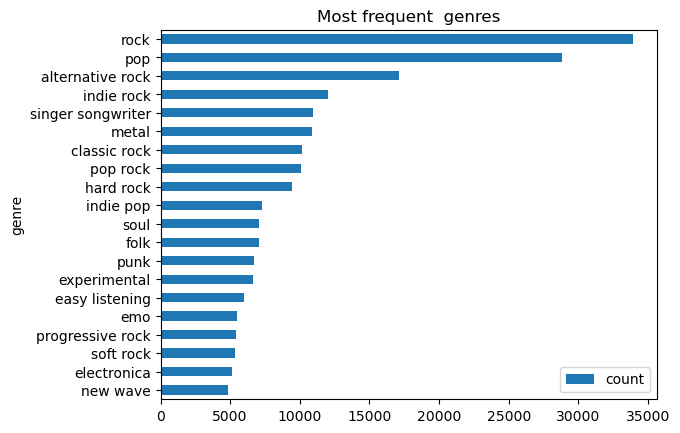

In [5]:
# Filter all genres which contain "pop"
def get_most_frequent_genres(genres_df):
    # Returns a dataframe with only pop genres
    all_genres_sum = []
    all_genres = []
    for genres in genres_df['genre']:
        for x in genres.split("'"):
            if (not ("[" in x or "]" in x or "," in x)):
                if x in all_genres:
                    all_genres_sum[all_genres.index(x)] += 1
                else:
                    all_genres.append(x)
                    all_genres_sum.append(1)
    return all_genres, all_genres_sum


dict_genres, dict_genres_sum = get_most_frequent_genres(genres_df)

pd.DataFrame({'genre': dict_genres, 'count': dict_genres_sum}).sort_values(by='count', ascending=False).head(20)[
::-1].plot.barh(x='genre', y='count', title="Most frequent  genres")
pass

# Find out how many tracks approximately share one genre.

In [6]:
def get_genres_matrix(genres_df):
    # Returns a dataframe with only pop genres
    all_genres = []
    for genres in genres_df['genre']:
        for x in genres.split("'"):
            if not ("[" in x or "]" in x or "," in x):
                if x not in all_genres:
                    all_genres.append(x)

    np_genres = np.zeros(shape=(len(genres_df), len(all_genres)))
    # fill the matrix
    for i, genres in enumerate(genres_df['genre']):
        for x in genres.split("'"):
            if (not ("[" in x or "]" in x or "," in x)):
                np_genres[i, all_genres.index(x)] = 1
    return np_genres, all_genres


genres_numbers, all_genres = get_genres_matrix(genres_df)
display("Number of genres: " + str(len(all_genres)))




'Number of genres: 1670'

In [7]:


def find_similar_genres(genres_numbers):
    # Find all columns which are 1 in the first row

    top_similar = []
    top_sums_values = []
    for column in range(0, genres_numbers.shape[1]):
        tmp_matrix = genres_numbers[genres_numbers[:, column] == 1]
        sum_matrix = np.sum(tmp_matrix, axis=0)
        # find biggest top_sum
        top_tmp = np.argpartition(sum_matrix, -10)[-10:]
        # We are sorting them and cutting the first value
        top_tmp = top_tmp[np.argsort(sum_matrix[top_tmp])][::-1][1:]
        top_sums_value = sum_matrix[top_tmp]
        top_similar.append((column, top_tmp))
        top_sums_values.append(top_sums_value)

    return top_sums_values, top_similar


# Display the top 3 genres which are most similar to the first genre
a, b = find_similar_genres(genres_numbers)

for i in range(0, genres_numbers.shape[1]):
    print("Genre: " + all_genres[i])
    for j in range(0, 3):
        print("Similar genre: " + all_genres[b[i][1][j]] + " with " + str(a[i][j]) + " tracks")
    print("")




Genre: pop
Similar genre: rock with 17048.0 tracks
Similar genre: pop rock with 8528.0 tracks
Similar genre: alternative rock with 8290.0 tracks

Genre: beats
Similar genre: pop with 274.0 tracks
Similar genre: electronica with 244.0 tracks
Similar genre: rock with 224.0 tracks

Genre: underground hip hop
Similar genre: hip hop with 287.0 tracks
Similar genre: rap with 260.0 tracks
Similar genre: alternative hip hop with 117.0 tracks

Genre: lo fi
Similar genre: rock with 1459.0 tracks
Similar genre: indie rock with 1391.0 tracks
Similar genre: indie pop with 980.0 tracks

Genre: hard rock
Similar genre: rock with 8919.0 tracks
Similar genre: alternative rock with 5220.0 tracks
Similar genre: metal with 4933.0 tracks

Genre: classic rock
Similar genre: rock with 9560.0 tracks
Similar genre: pop with 6121.0 tracks
Similar genre: hard rock with 4448.0 tracks

Genre: rock
Similar genre: pop with 17048.0 tracks
Similar genre: alternative rock with 15652.0 tracks
Similar genre: indie rock w

# Discussion:
We can see, that most songs are dominated by the most popular genres. If you are in an "unlikely" genre, it is hard to recommend a similar songs, because there aren't that many similar.

# Baseline with lyrics

Preprocessing to visualize.

In [8]:
def filter_df(df, **args):
    if not args:
        raise AttributeError("**args required")
    query = ''
    for k, v in args.items():
        query += f"{k}=='{v}' and "
    query = query[:-5]  # Removing the last 'and' of our query
    return df.query(query)

In [9]:
def get_genre(song_id_):
    genre = genres_df[genres_df.id == song_id_]["genre"].values
    return genre

In [10]:
import ast


def get_result_genre(song_ids_, example_id):
    """
    Converts the list of ids to a usable result dataframe

    :param song_ids_: list of ids
    :return: dataframe with query_genre and similar_genres
    """
    df = pd.DataFrame()
    df["similar"] = song_ids_
    df["query_id"] = [example_id for _ in range(len(df))]
    df["query_genre"] = df.query_id.apply(lambda x: ast.literal_eval(get_genre(x)[0])[0])
    df["similar_genre"] = df.similar.apply(lambda x: ast.literal_eval(get_genre(x)[0]))
    # Calculate if the genre is in the query genre
    df["similar_genre_value"] = df[["query_genre", "similar_genre"]].apply(
        lambda x: 1 if x["query_genre"] in x["similar_genre"] else 0,
        axis=1)
    df.drop(["similar", "query_id"], axis=1, inplace=True)
    df["query_genre_value"] = [0 for _ in range(len(df))]
    return df

In [11]:
# usage:
#   1. get query song id by using "filter_df" on merged info_df & embedding_df (filter by artist & song)
#   2. call top_k_similar with song id from step 1

def top_k_similar(id, embedding_array, k=None, similarity_measure=cosine_similarity):
    """
    Return top k similar songs and their scores given an embedding and similarity meassure
    :param  id: song id
            embedding_array: embedding array to base similarities on
            k: the number of most similar songs to return
            similarity_measure: a function which returns the pairwise similarity of data points
    :return: list of top k songs and their scores
    """
    Y = embedding_array[embedding_array[:, 0] == id].reshape(1, -1)[:, 1:]
    if Y.shape == (1, 0):
        return None
    similarities = similarity_measure(X=embedding_array[:, 1:],
                                      Y=Y).reshape(-1)
    most_similar = [[this_id, this_sim] for this_sim, this_id in sorted(zip(similarities, embedding_array[:, 0]))][::-1]
    if k is None:
        return most_similar[1:]
    return most_similar[1:k + 1]

# Precision metrics

In [12]:
def mean_reciprocal_rank(result_df, relevant_col="similar_genre"):
    """
    Calculates the mean reciprocal rank of the result dataframe

    :param result_df: dataframe with query_genre and similar_genres
    :return: mean reciprocal rank
    """
    sum = 0
    for i, row in result_df.iterrows():
        counter = 0
        for genre in row[relevant_col]:
            counter += 1
            if row["query_genre"] == genre:
                sum += 1 / counter
                break

    return sum / len(result_df)


def precision(df, relevant_col="similar_genre_value"):
    """
    Calculates the r-precision of the result dataframe

    :param df: dataframe with query_genre and similar_genres
    """
    return df[relevant_col].sum() / len(df)


# define ndcg function
def ndcg(result_df, relevant_col="similar_genre_value"):
    """
    Calculates the ndcg score for a given result vector

    :param result_vector: vector of results
    :return: ndcg score
    """
    # Calculate the dcg
    dcg = 0
    for i in range(len(result_df)):
        dcg += result_df[relevant_col][i] / np.log2(i + 2)

    # Calculate the idcg
    idcg = 0
    for i in range(len(result_df)):
        idcg += 1 / np.log2(i + 2)
    return dcg / idcg

# Framework

In [13]:
from scipy import sparse


# I imported my LSA solution from another notebook. For our case we do not need the u and sigma_inv.

def LSA(matrix, k):
    # calculate the svd
    print("calculating svd, takes some time")
    u, s, vt = sparse.linalg.svds(matrix, k=k)
    # create m x k matrix
    s = np.diag(s)

    return u, np.linalg.inv(s), vt.T


def inference(matrix, u, sigma_inv):
    return (sigma_inv @ u.T @ matrix.T).T



In [15]:
# Because running all those functions is tedious we add a framework

import time

def recommender(embedding_array, artist=None, song=None, example_id=None, k=10,
                similarity_measure=cosine_similarity,
                only_stat=False):
    """
    Framework to run the recommender system

    :param example_artist: artist of the query song
    :param example_song: song of the query song
    :param k: number of similar songs
    :param similarity_measure: similarity measure to use
    :return: result dataframe
    """
    # Filter the dataframe to get the song id
    if example_id is None:
        example_id = filter_df(info_df, artist=artist, song=song).to_numpy()[0, 0]
    # Get the top k similar songs
    similar_k = top_k_similar(example_id, embedding_array, k=k, similarity_measure=similarity_measure)

    # IF the song is not in the embedding array return None
    if similar_k == None:
        return [0, 0, 0]
    similar_id = list(next(zip(*similar_k)))
    # Get the result dataframe
    result = get_result_genre(similar_id, example_id)

    if only_stat == True:
        return np.array([precision(result), mean_reciprocal_rank(result), ndcg(result)])

    stat = {"precision": precision(result),
            "mrr": mean_reciprocal_rank(result),
            "ndcg": ndcg(result)}

    return result, stat, similar_id


In [16]:
def recommender_evaluation_framework(embedding_array, k=10, similarity_measure=cosine_similarity, breakpoint=False):
    """
    Framework to evaluate the recommender system

    :param k: number of similar songs
    :param similarity_measure: similarity measure to use
    :return: result dataframe
    """
    stat = [0, 0, 0]
    for index, row in tqdm(info_df.iterrows(), total=len(info_df)):
        stat += recommender(example_id=row["id"], embedding_array=embedding_array, k=k, similarity_measure=similarity_measure, only_stat=True)
        if index == breakpoint:
            return stat / breakpoint

    return sum(stat) / len(info_df)

# Execution Part : Lyrics

In [17]:
# Importing the lyrics data
tfidf_ids, tfidf_array = data_loader("id_lyrics_tf-idf_mmsr.tsv")
word2vec_ids, word2vec_array = data_loader("id_lyrics_word2vec_mmsr.tsv")
bert_ids, bert_array = data_loader("id_lyrics_bert_mmsr.tsv")

In [18]:
# adjusting the lyrics data
u, sigma_inv_1, tf_idf_small = LSA(tfidf_array[:, 1:].astype(np.float32).T, 10)
tf_idf_small = np.concatenate((tfidf_ids[:, None], tf_idf_small), axis=1)  #concatenate the id column again

#u, sigma_inv_1, word2vec_small = LSA(word2vec_array[:, 1:].astype(np.float32).T, 10)
#word2vec_small = np.concatenate((word2vec_ids[:, None], word2vec_small), axis=1)  #concatenate the id column again

#u, sigma_inv_1, bert_small = LSA(bert_array[:, 1:].astype(np.float32).T, 10)
#bert_small = np.concatenate((bert_ids[:, None], bert_small), axis=1)  #concatenate the id column again

calculating svd, takes some time


In [20]:

result, stat, similar_id = recommender(tf_idf_small,"Elton John", "Nikita", k=10, similarity_measure=cosine_similarity, )
print(stat)
display(info_df.where(info_df.id.isin(similar_id)).dropna())

{'precision': 0.6, 'mrr': 0.3142857142857143, 'ndcg': 0.5501126236272343}


,id,artist,song,album_name
2847,2Tud1sKdzCfsgNuO,AFI,Hidden Knives,AFI (The Blood Album)
5766,54aJymX23XS3azJ3,Madeon,Beings,Adventure (Deluxe)
5789,569DDnQOSEyuJug9,Coldplay,Trouble,Parachutes
22903,KgU8jEngGmoWL33H,Blonde Redhead,Hated Because of Great Qualities,Melody of Certain Damaged Lemons
30097,R5kPPdlImSImgJXZ,Kelly Clarkson,I Hate Myself for Losing You,Breakaway
41338,bML5G3n9zcOK3V35,Glee Cast,Sweet Caroline,"Glee: The Music, Volume 1"
42482,cNylkOoSfpQ0Nnax,Townes Van Zandt,For The Sake of The Song,Townes Van Zandt
51472,kVMIjrvZHp021nv1,The Rolling Stones,The Last Time,Out Of Our Heads
62339,uIwvTI9FgpVE5jMZ,Girls Aloud,100 Different Ways,The Collection - Studio Albums / B Sides / Live
64738,wS29hpE8uaEO3y3t,Beach House,Wedding Bell,Devotion


In [ ]:
embedding_arrays = {
    "tf_idf_small": tf_idf_small
    #"word2vec_small": word2vec_small,
    #"bert_small": bert_small
}

similarity_measures = {
    "cosine_similarity": cosine_similarity,
    "manhattan_distances": manhattan_distances,
}

result = []
for embedding_array_name in embedding_arrays.keys():
    for similarity_measure_name in similarity_measures.keys():
        stat = [embedding_array_name, similarity_measure_name]
        stat.extend(recommender_evaluation_framework(embedding_array=embedding_arrays[embedding_array_name],
                                                     k=10,
                                                     similarity_measure=similarity_measures[similarity_measure_name],
                                                     breakpoint=10))
        result.append(stat)
result = pd.DataFrame(data=result, columns=["embedding", "smilarity_measure", "precision", "mmr", "ndcg"])
display(result)

# Execution Part : Audio

In [38]:
# Considering the fact that the id's might not always be in order, we extract them.
locfluc_ids, locfluc_array = data_loader("id_blf_logfluc_mmsr.tsv")
resnet_ids, resnet_array = data_loader("id_resnet_mmsr.tsv")
spectral_ids, spectral_array = data_loader("id_blf_spectral_mmsr.tsv")
mfcc_ids, mfcc_array = data_loader("id_mfcc_bow_mmsr.tsv")

# replace nAn values with 0
locfluc_array = np.nan_to_num(locfluc_array)
resnet_array = np.nan_to_num(resnet_array)
spectral_array = np.nan_to_num(spectral_array)
mfcc_array = np.nan_to_num(mfcc_array)

In [39]:
spectral_small = np.concatenate((spectral_ids[:, None], spectral_array), axis=1)  #concatenate the id column again
mfcc_small = np.concatenate((mfcc_ids[:, None], mfcc_array), axis=1)  #concatenate the id column again
locfluc_small = np.concatenate((locfluc_ids[:, None], locfluc_array), axis=1)  #concatenate the id column again
resnet_small = np.concatenate((resnet_ids[:, None], resnet_array), axis=1)  #concatenate the id column again

In [40]:
result, stat, similar_id = recommender(spectral_small,"Elton John", "Nikita", k=10, similarity_measure=cosine_similarity)
print(stat)
display(info_df.where(info_df.id.isin(similar_id)).dropna())

{'precision': 0.6, 'mrr': 0.41666666666666663, 'ndcg': 0.7007731679885374}


,id,artist,song,album_name
75,03v7PvCepe2N5A6V,Joni Mitchell,Dog Eat Dog,Dog Eat Dog
15173,DcEMV6Vaej8aBSJa,Prefab Sprout,Enchanted,From Langley Park To Memphis
23473,LCf0x3hG5pCDaK1j,Dexter Wansel,The Sweetest Pain,Time Is Slipping Away
23886,LaQiGfbP2Epc2qUQ,Cock Robin,The Promise You Made,80s 100 Hits
37993,YDT8zHM72DSDosah,Spandau Ballet,True,True - The Digital E.P.
41228,bGFrJMQh3yQYPaiZ,Toto,Till the End,Fahrenheit
47838,hDXxPsLdf7xEJHwO,Soda Stereo,Signos,Signos (Remastered)
49337,iZC9u57u2O2ZU9Ev,KLB,A Cada Dez Palavras,KLB 2002
62991,uuuQsbpSrLSjms9Y,Depeche Mode,Just Can't Get Enough,Speak & Spell (2006 Remastered Edition)
65893,xT9uHCSgcuvmNH7E,Bruce Hornsby,Mandolin Rain,The Way It Is


In [41]:
embedding_arrays = {
    "locfluc_small": locfluc_small,
    "resnet_small": resnet_small,
    "spectral_small": spectral_small,
    "mfcc_small": mfcc_small
}

similarity_measures = {
    "cosine_similarity": cosine_similarity,
    "manhattan_distances": manhattan_distances,
}

result = []
for embedding_array_name in embedding_arrays.keys():
    for similarity_measure_name in similarity_measures.keys():
        stat = [embedding_array_name, similarity_measure_name]
        stat.extend(recommender_evaluation_framework(embedding_array=embedding_arrays[embedding_array_name],
                                                     k=10,
                                                     similarity_measure=similarity_measures[similarity_measure_name],
                                                     breakpoint=10))
        result.append(stat)
result = pd.DataFrame(data=result, columns=["embedding", "smilarity_measure", "precision", "mmr", "ndcg"])
display(result)

  0%|          | 10/68641 [00:11<21:02:48,  1.10s/it]


,embedding,smilarity_measure,precision,mmr,ndcg
0,locfluc_small,cosine_similarity,0.40,0.242659,0.440615
1,locfluc_small,manhattan_distances,0.20,0.121167,0.247835
2,resnet_small,cosine_similarity,0.42,0.273444,0.477796
3,resnet_small,manhattan_distances,0.26,0.107902,0.256141
4,spectral_small,cosine_similarity,0.39,0.221771,0.404032
5,spectral_small,manhattan_distances,0.18,0.097059,0.150815
6,mfcc_small,cosine_similarity,0.43,0.300790,0.453705
7,mfcc_small,manhattan_distances,0.25,0.099059,0.233472
